In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Data Summary

In [2]:
train = pd.read_csv('./Data/carInsurance_train.csv', dtype={'CarInsurance':'int64'})
test = pd.read_csv('./Data/carInsurance_test.csv', dtype={'CarInsurance':object})
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

In [3]:
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [4]:
print(f'Train has {train.shape[0]} observations')
print(f'Test has {test.shape[0]}  observations')

Train has 4000 observations
Test has 1000  observations


In [5]:
print(train.groupby('CarInsurance', dropna=False).count()['Id'])
print(test.groupby('CarInsurance', dropna=False).count()['Id'])

CarInsurance
0    2396
1    1604
Name: Id, dtype: int64
CarInsurance
NaN    1000
Name: Id, dtype: int64


Outcome values seem to have been removed from the test data, so it can't be used for a final evaluation of classifier performance. Instead we can split the training set again later

The data is unblanced with more negative outcomes than positive ones. I don't think there is a particulary high cost associated with either False Positives and False Negative.
So F1 score might be a better metric to measure the classifier on than accuracy, precision or recall 

# Features

The actual call start time and call time, probably won't matter as much as the acutal duration of the call so we can create a new column with that metric 

In [264]:
train['CallStart'] =  pd.to_datetime(train['CallStart'], format= '%H:%M:%S')
train['CallEnd'] =  pd.to_datetime(train['CallEnd'],format= '%H:%M:%S')
train["CallDuration"]= train["CallEnd"] -train['CallStart'] 
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,CallDuration
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,1900-01-01 13:45:20,1900-01-01 13:46:30,0,0 days 00:01:10
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,1900-01-01 14:49:03,1900-01-01 14:52:08,0,0 days 00:03:05
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,1900-01-01 16:30:24,1900-01-01 16:36:04,1,0 days 00:05:40
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,1900-01-01 12:06:43,1900-01-01 12:20:22,1,0 days 00:13:39
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,1900-01-01 14:35:44,1900-01-01 14:38:56,0,0 days 00:03:12


In [265]:
train['CallDuration']= (train['CallDuration'] / np.timedelta64(1, 'm')).round(1)
train = train.drop('CallStart', axis=1)
train = train.drop('CallEnd', axis=1)
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CarInsurance,CallDuration
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,0,1.2
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,0,3.1
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,1,5.7
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,1,13.6
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,0,3.2


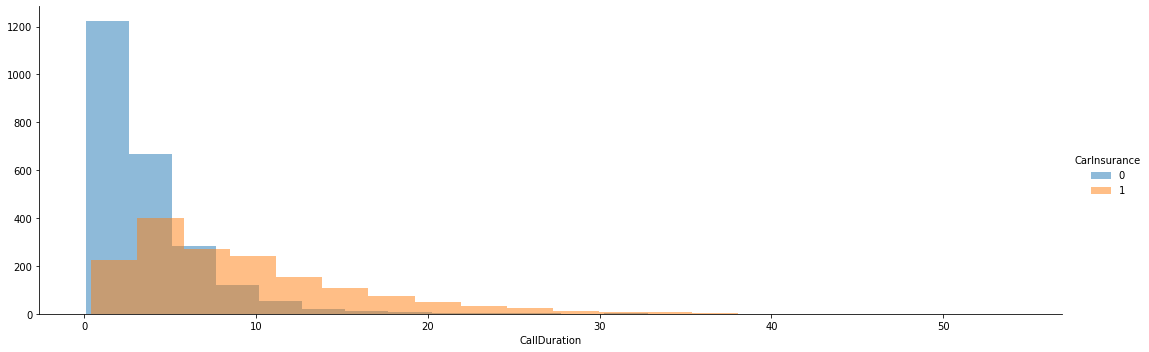

In [266]:
facet = sns.FacetGrid(train_reduced, hue='CarInsurance',height=5,aspect=3)
facet.map(plt.hist,'CallDuration',bins=20,alpha=0.5)
facet.add_legend()

Taking a closer look at the CallDuration metric, as a general trend longer calls lead to a higher ratio of sales than shorter calls.

Addtionally LastContactDay (as day of the month) might not be as relevant as the day of the week contact was made. On the other hand the calendar day might still be relevant. For example people usually have more money at the beginng of the month than at the end. So we can keep both metrics.

Assumption here is that the year is 2016 (the year the data was uploaded)

In [267]:
#assuming 2016, last full year before upload
train['LastContactDate'] = train.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)
train['LastContactDayOfWeek'] = train['LastContactDate'].dt.weekday
train['LastContactDayOfWeek'] = pd.to_numeric(train['LastContactDayOfWeek'])
train = train.drop('LastContactDate', axis=1)
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CarInsurance,CallDuration,LastContactDayOfWeek
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,0,1.2,3
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,0,3.1,3
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,1,5.7,4
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,1,13.6,2
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,0,3.2,4


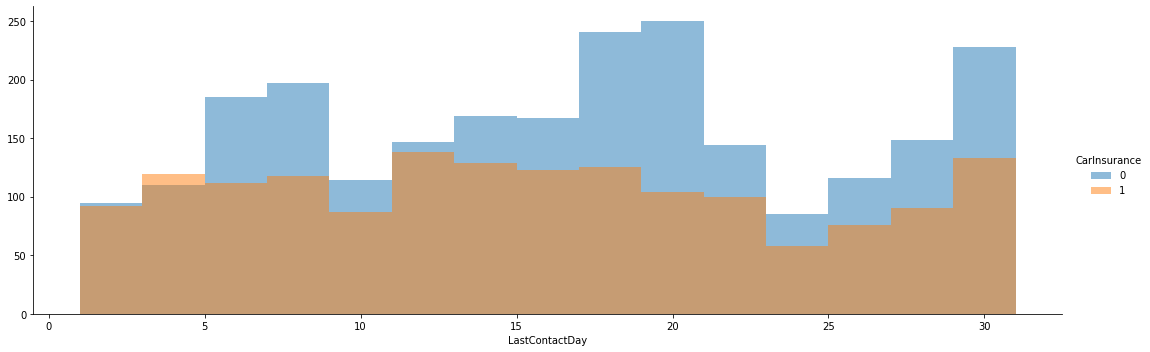

In [6]:
facet = sns.FacetGrid(train, hue='CarInsurance',height=5,aspect=3)
facet.map(plt.hist,'LastContactDay',bins=15,alpha=0.5)
facet.add_legend()

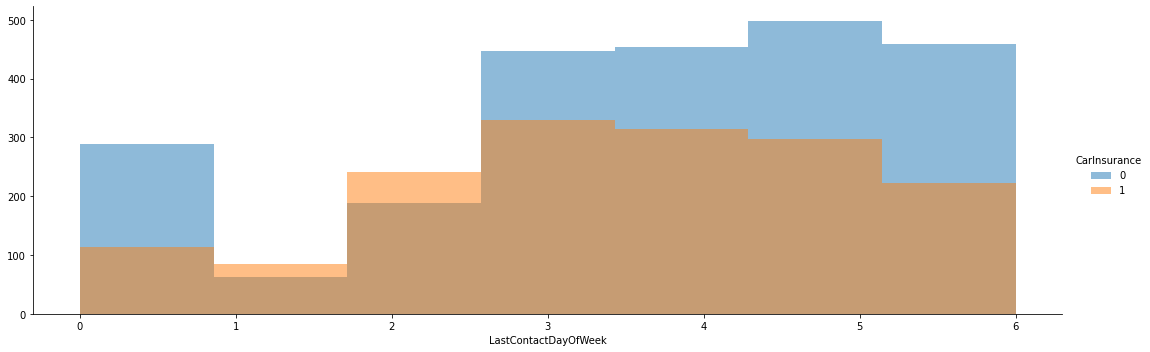

In [269]:
facet = sns.FacetGrid(train, hue='CarInsurance',height=5,aspect=3)
facet.map(plt.hist,'LastContactDayOfWeek',bins=7,alpha=0.5)
facet.add_legend()

## Missing Values 

In [ ]:
train= train.drop('Id', axis=1)
print((train.isna().sum()/len(train))*100)

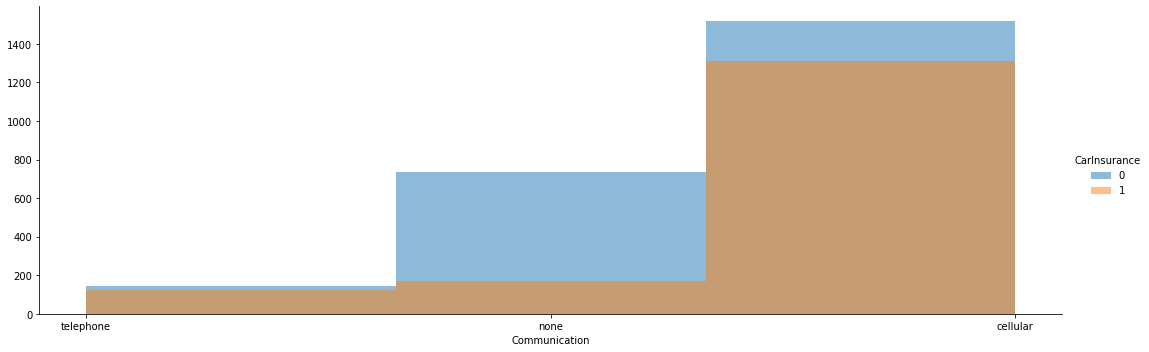

In [270]:
# replace missing communication values with none 
train["Communication"]=train["Communication"].fillna("none")
facet = sns.FacetGrid(train, hue='CarInsurance',height=5,aspect=3)
facet.map(plt.hist,'Communication',bins=3,alpha=0.5)
facet.add_legend()

Missing communication values, seem to have a lower success rate than both telephone and cellular 

Categorical values need to be encoded so they can be included in the correlation matrix below and used in the classification 

In [7]:
#encode categorical values 
le = LabelEncoder()
df_en=train
df_en['Job'] = le.fit_transform(train['Job'])
df_en['Marital'] = le.fit_transform(train['Marital'])
df_en['Education'] = le.fit_transform(train['Education'])
df_en['Communication'] = le.fit_transform(train['Communication'])
df_en['LastContactMonth'] = le.fit_transform(train['LastContactMonth'])
df_en['Outcome'] = le.fit_transform(train['Outcome'])

df_en.head()




,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,4,2,2,0,1218,1,0,1,28,4,2,-1,0,3,13:45:20,13:46:30,0
1,2,32,1,1,0,0,1156,1,0,2,26,8,5,-1,0,3,14:49:03,14:52:08,0
2,3,29,4,2,2,0,637,1,0,0,3,6,1,119,1,0,16:30:24,16:36:04,1
3,4,25,8,2,0,0,373,1,0,0,11,8,2,-1,0,3,12:06:43,12:20:22,1
4,5,30,4,1,2,0,2694,0,0,0,3,6,1,-1,0,3,14:35:44,14:38:56,0


In [8]:
corr = df_en.corr().abs() 
cm = sns.light_palette("green", as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CarInsurance
Id,1.00,0.00,0.01,0.02,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.02,0.01,0.01,0.01,0.00,0.02
Age,0.00,1.00,0.04,0.43,0.13,0.00,0.09,0.18,0.01,0.02,0.01,0.03,0.03,0.02,0.00,0.02,0.04
Job,0.01,0.04,1.00,0.08,0.14,0.01,0.01,0.15,0.04,0.09,0.04,0.06,0.00,0.03,0.03,0.03,0.08
Marital,0.02,0.43,0.08,1.00,0.14,0.01,0.00,0.02,0.02,0.05,0.02,0.02,0.02,0.04,0.03,0.04,0.05
Education,0.01,0.13,0.14,0.14,1.00,0.03,0.05,0.11,0.05,0.11,0.02,0.05,0.01,0.02,0.03,0.04,0.09
Default,0.00,0.00,0.01,0.01,0.03,1.00,0.05,0.01,0.12,0.02,0.03,0.01,0.03,0.03,0.03,0.04,0.04
Balance,0.01,0.09,0.01,0.00,0.05,0.05,1.00,0.07,0.08,0.04,0.02,0.01,0.01,0.00,0.00,0.02,0.04
HHInsurance,0.00,0.18,0.15,0.02,0.11,0.01,0.07,1.00,0.09,0.20,0.02,0.22,0.01,0.08,0.03,0.08,0.20
CarLoan,0.00,0.01,0.04,0.02,0.05,0.12,0.08,0.09,1.00,0.02,0.01,0.03,0.02,0.04,0.02,0.02,0.09
Communication,0.00,0.02,0.09,0.05,0.11,0.02,0.04,0.20,0.02,1.00,0.01,0.29,0.04,0.23,0.17,0.26,0.23


All columns with Nan values have fairly correlations to the outcome, so we might get away with dropping them all together 

In [275]:
# low correlations so we drop 
df_en=df_en.drop('Outcome',axis=1)
df_en=df_en.drop('Job',axis=1)
df_en=df_en.drop('Education',axis=1)


Taking a closer look at (non 0/1 ) values with high correlation to the output. 

A higher number of contacts seems to in general deter customers. PrevAttempts behaves similar but a much lesser extend and with some outliers for positives outcomes. 

In [276]:
target = corr["CarInsurance"]
features = target[target>=0.1]
print("most relevant features: ")
print(features)

most relevant features: 
HHInsurance      0.203419
Communication    0.136901
NoOfContacts     0.114884
DaysPassed       0.138943
PrevAttempts     0.148763
CarInsurance     1.000000
CallDuration     0.480229
Name: CarInsurance, dtype: float64


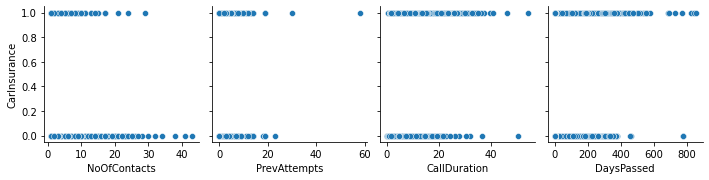

In [279]:
sns.pairplot(train,   y_vars=['CarInsurance'],
                  x_vars=['NoOfContacts', 'PrevAttempts','CallDuration', 'DaysPassed']);

# Classification 

In [199]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring="f1"):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
def create_validation_curve(x, y, learner, param, param_range, scoring="f1", title="", ymin=0, ymax=1.01):
    train_scores, test_scores = validation_curve(
        learner, x, y, param_name=param, param_range=param_range,
        scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.ylim(ymin, ymax)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy")
    plt.legend(loc="best")
    plt.show()



In [280]:
x = df_en.drop('CarInsurance', axis=1)
y = df_en['CarInsurance']
x, X_test, y, y_test = train_test_split( x, y, test_size=0.33, random_state=42)


## Random Forest

The learning curve for default parameters shows low bias and high variance. The model appears to be overfitting, so we can look at some hyperparameters that might reduce over fitting. 

In [ ]:
learner = RandomForestClassifier(random_state=0)
plt=plot_learning_curve(learner, "Learning Curve -Random Forest - default", x,y, train_sizes=[ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [ ]:
depths=[1,2,5,10,15,20,30]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "max_depth", depths, title="Validation Curve- RF - max depth")



In [ ]:
alphas=[0.0,0.0001,0.001,0.001]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "ccp_alpha", alphas, title="Validation Curve- RF - post pruning")

In [ ]:
estimators=[2,3,5,7,10,20,40,]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "n_estimators", estimators, title="Validation Curve- RF - estimators")

Run GridSearchCV with a reduced search space derived from the validation curves above, where the selected value attempt to achieve a decent bias/ variance balance


In [ ]:
parameters = {'n_estimators':[5,6,7], 
              'ccp_alpha':[0.0003,0.0004, 0.0005], 
              'max_depth':[5,6,7,8,9]}
clf  = GridSearchCV(estimator = RandomForestClassifier(random_state=0),param_grid = parameters,cv=3, scoring="f1")
clf .fit(x,y)
        
print(clf.best_params_)

In [ ]:
learner = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
plt=plot_learning_curve(learner, "Learning Curve -Random Forest", x,y, train_sizes=[ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [ ]:
rf = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
rf.fit(x,y)
score= f1_score( y_test, rf.predict(X_test) )
acc=  accuracy_score( y_test, rf.predict(X_test) )
print("Accuracy", acc)
print("F1 Score: ", score )

In [ ]:
plot_confusion_matrix(rf, X_test, y_test) 

In [ ]:
depths=[1,2,5,10,15,20,30]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "max_depth", depths, title="Validation Curve- RF - max depth")



In [ ]:
alphas=[0.0,0.0001,0.001,0.001]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "ccp_alpha", alphas, title="Validation Curve- RF - post pruning")

In [ ]:
estimators=[2,3,5,7,10,20,40,]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "n_estimators", estimators, title="Validation Curve- RF - estimators")

Run GridSearchCV with a reduced search space derived from the validation curves above, where the selected value attempt to achieve a decent bias/ variance balance


In [ ]:
parameters = {'n_estimators':[5,6,7], 
              'ccp_alpha':[0.0003,0.0004, 0.0005], 
              'max_depth':[5,6,7,8,9]}
clf  = GridSearchCV(estimator = RandomForestClassifier(random_state=0),param_grid = parameters,cv=3, scoring="f1")
clf .fit(x,y)
        
print(clf.best_params_)

In [ ]:
learner = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
plt=plot_learning_curve(learner, "Learning Curve -Random Forest", x,y, train_sizes=[ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [ ]:
rf = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
rf.fit(x,y)
score= f1_score( y_test, rf.predict(X_test) )
acc=  accuracy_score( y_test, rf.predict(X_test) )
print("Accuracy", acc)
print("F1 Score: ", score )

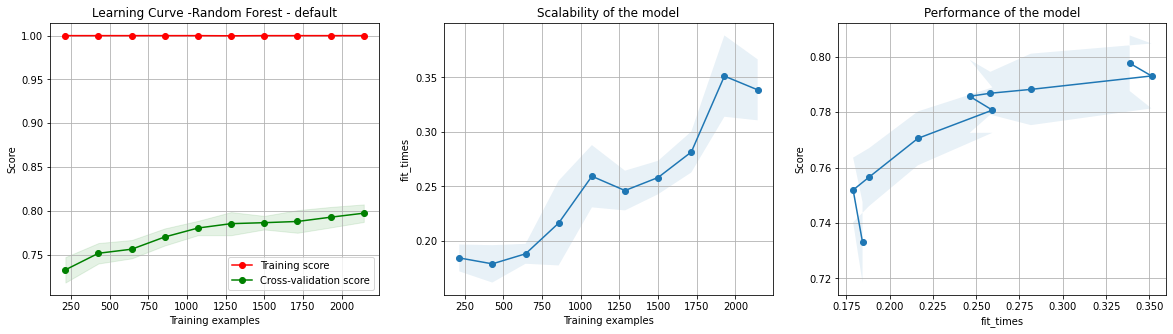

In [182]:
plot_confusion_matrix(rf, X_test, y_test) 

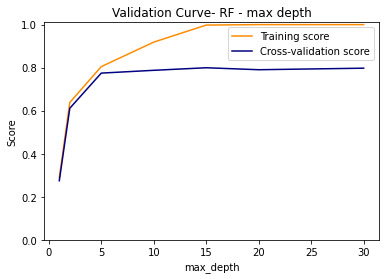

In [170]:
depths=[1,2,5,10,15,20,30]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "max_depth", depths, title="Validation Curve- RF - max depth")



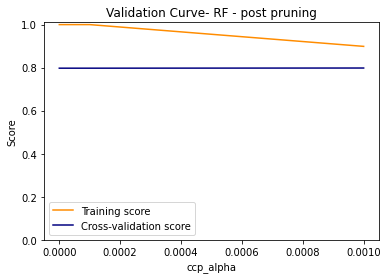

In [189]:
alphas=[0.0,0.0001,0.001,0.001]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "ccp_alpha", alphas, title="Validation Curve- RF - post pruning")

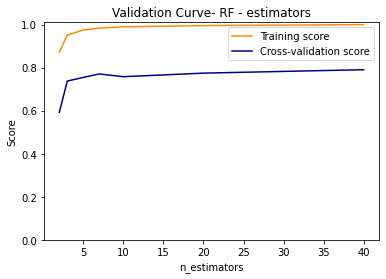

In [190]:
estimators=[2,3,5,7,10,20,40,]
learner = RandomForestClassifier(random_state=0)
create_validation_curve(x,y, learner, "n_estimators", estimators, title="Validation Curve- RF - estimators")

Run GridSearchCV with a reduced search space derived from the validation curves above, where the selected value attempt to achieve a decent bias/ variance balance


In [191]:
parameters = {'n_estimators':[5,6,7], 
              'ccp_alpha':[0.0003,0.0004, 0.0005], 
              'max_depth':[5,6,7,8,9]}
clf  = GridSearchCV(estimator = RandomForestClassifier(random_state=0),param_grid = parameters,cv=3, scoring="f1")
clf .fit(x,y)
        
print(clf.best_params_)

{'ccp_alpha': 0.0003, 'max_depth': 9, 'n_estimators': 7}


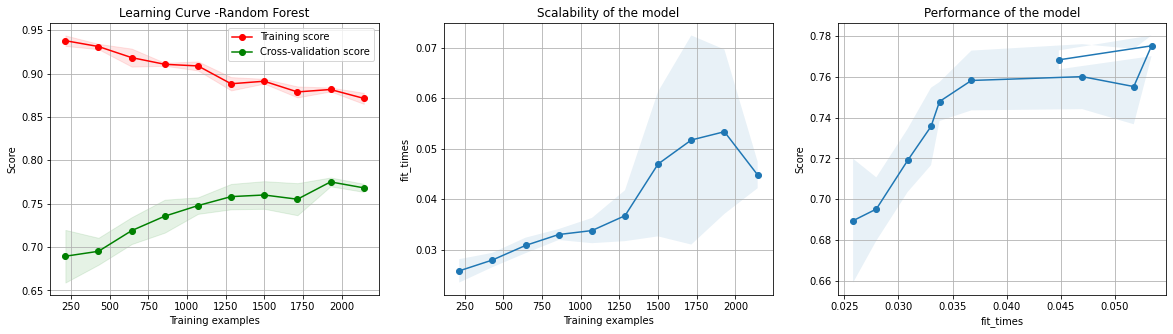

In [192]:
learner = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
plt=plot_learning_curve(learner, "Learning Curve -Random Forest", x,y, train_sizes=[ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.show()

In [282]:
rf = RandomForestClassifier(ccp_alpha= 0.0003, max_depth= 9, n_estimators= 7, random_state=0)
rf.fit(x,y)
score= f1_score( y_test, rf.predict(X_test) )
acc=  accuracy_score( y_test, rf.predict(X_test) )
print("Accuracy", acc)
print("F1 Score: ", score )

Accuracy 0.821969696969697
F1 Score:  0.7720659553831232


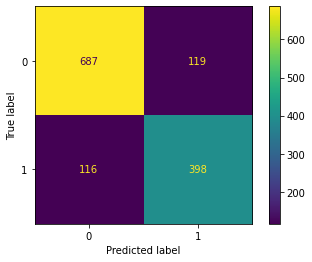

In [283]:
plot_confusion_matrix(rf, X_test, y_test) 